In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [2]:
def load_json(filename):
    with open(filename, 'r') as f:
        loaded_obj = json.load(f)
        
    return loaded_obj

In [3]:
chi_type = 'chi2'

In [4]:
js_results = load_json(f'../data/ATLAS_MD/output_js_results/ATLAS_proteins_js_pdbensemble_results_{chi_type}.json')
js_results_multi = load_json(f'../data/ATLAS_MD/output_js_results/ATLAS_proteins_js_pdbensemble_multiresis_results_{chi_type}.json')
js_results_fixed= load_json(f'../data/ATLAS_MD/output_js_results/ATLAS_proteins_js_pdbensemble_fixedresis_results_{chi_type}.json')

In [5]:
def plot_boxplot_with_points_density(*args, colors=None,labels=None, title=None,ylabel=r'$JS_{div}$',spread_scale=1, labelsize=22):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """
        
    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k','linewidth':2.},
    'medianprops':{'color':'k','linewidth':2.},
    'whiskerprops':{'color':'k','linewidth':2.},
    'capprops':{'color':'k'}
    }

    # Create the figure and axis
    plt.figure(figsize=(17, 4))

    meanprops = {'color': 'red', 'linewidth': 20}
    # Plot the boxplot
    sns.boxplot(data=args, width=0.2,showmeans=True, meanprops=meanprops,**PROPS)
    
    for i, data in enumerate(args):
        w,r=np.histogram(data,bins=40, density=True)
        # Add jitter to avoid points overlapping
        x = spread_points_normal(data, bins=30, loc= i+0.4, std_factor=spread_scale)

        # Plot the raw data points
        if colors:
            for j, (x_val, y_val) in enumerate(zip(x, data)):
                plt.scatter(x_val, y_val, color=colors[j], alpha=0.7,edgecolor='w',s=10)
        else:
            plt.plot(x, data, 'k.', alpha=0.5, ms=5)
    plt.ylim(-0.01,1)
    plt.yticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize=labelsize)
    plt.ylabel(ylabel, fontsize=labelsize)
    plt.grid(axis='y',alpha=0.2,zorder=-200)
    # Add labels if provided
    if labels:
        plt.xticks(np.arange(len(args))+0.2, labels, fontsize=labelsize)
    
    # Add title if provided
    if title:
        plt.title(title)

def plot_boxplot(*args, labels=None, title=None,box_color='#d55c00',width=10,height=5, labelsize=22):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """

    PROPS = {
    'boxprops':{'facecolor':box_color, 'edgecolor':'k','linewidth':2.},
    'medianprops':{'color':'k','linewidth':2.},
    'whiskerprops':{'color':'k','linewidth':2.},
    'capprops':{'color':'k'}
    }

    # Create the figure and axis
    plt.figure(figsize=(17, 4))
    meanprops = {'color': 'red', 'linewidth': 20}
    # Plot the boxplot
    sns.boxplot(data=args, width=0.2,showmeans=True, meanprops=meanprops,**PROPS)
    
    plt.ylim(-0.01,1)
    #plt.ylabel(ylabel, fontsize=labelsize)
    # Add labels if provided
    if labels:
        plt.xticks(range(len(args)), labels, fontsize=labelsize)
    
    # Add title if provided
    if title:
        plt.title(title)

def spread_points_normal(data, bins=10, loc=1.0, std_factor=1.0):

    # Compute histogram with specified number of bins
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    
    # Determine the bin index for each point
    bin_indices = np.digitize(data, bins=bin_edges, right=False) - 1  # Adjust index to 0-based
    bin_indices = np.clip(bin_indices, 0, bins - 1)  # Ensure no out-of-range indices

    # Compute bin centers

    # Create x-coordinates for each point
    x = np.zeros_like(data)
    for i in range(bins):
        # Points in the current bin
        points_in_bin = (bin_indices == i)
        num_points = np.sum(points_in_bin)

        # Spread points normally around the bin center inversely proportional to density
        if num_points > 0:
            std_dev = hist[i] * std_factor * np.sqrt(len(data))  # Adjust standard deviation
            #print(loc,std_dev)

            x[points_in_bin] = np.random.normal(
                loc=loc,       # Center of the normal distribution
                scale=std_dev,    # Adjusted spread
                size=num_points   # Number of points in the bin
            )
    return x

# Filter pdb ensembles

In [6]:
uniprot_ids_skip = ['O83774', 'P05327', 'P09598', 'P0CJ63', 'P22088', 'P26276', 'P26602', 'P31101', 'P74102', 'Q9R4E4'] #less than 10 structures

In [7]:
pdbens_files = glob.glob('../data/ATLAS_MD/ATLAS_pdbensembles/*.json')
uniprot_ids = []

for file in pdbens_files:
    filename = os.path.basename(file)  # e.g., "P12345_someinfo.json"
    uniprot_id = filename[:6]  # assuming the UniProt ID is always the first 6 characters
    if uniprot_id not in uniprot_ids_skip:
        uniprot_ids.append(uniprot_id)
    else:
        print(f'Skipping {uniprot_id}')

Skipping P26602
Skipping O83774
Skipping P0CJ63
Skipping P31101
Skipping P22088
Skipping P26276
Skipping Q9R4E4
Skipping P09598
Skipping P05327


In [8]:
ATLAS_info_file = '../data/ATLAS_MD/2022_06_13_ATLAS_info.tsv'

pdbs = []
pdb2uniprot= {}
ATLAS_info = np.genfromtxt(ATLAS_info_file, dtype=str, skip_header=1, usecols=(0,5))
for uniprot_id in uniprot_ids:
    for info in ATLAS_info:
        if uniprot_id == info[1]:
            pdb = info[0]
            pdbs.append(pdb)
            pdb2uniprot[pdb] = uniprot_id

In [9]:
js_results_arrs = {}
for ensemble_model in js_results.keys():
    js_vs_residues_all = np.array([])
    for pdb in js_results[ensemble_model].keys():
        if pdb in pdbs:
            js_vs_residues_all = np.concatenate((js_vs_residues_all, js_results[ensemble_model][pdb]))
        else:
            print(f'Skipping {pdb}')
    js_results_arrs[ensemble_model] = js_vs_residues_all

Skipping 1tez_B
Skipping 2gg6_A
Skipping 1tt8_A
Skipping 1gnt_A
Skipping 1ys1_X
Skipping 3dha_A
Skipping 1ah7_A
Skipping 4xdu_A
Skipping 1p5g_X
Skipping 1tez_B
Skipping 2gg6_A
Skipping 1tt8_A
Skipping 1gnt_A
Skipping 1ys1_X
Skipping 3dha_A
Skipping 1ah7_A
Skipping 4xdu_A
Skipping 1p5g_X
Skipping 1tez_B
Skipping 2gg6_A
Skipping 1tt8_A
Skipping 1gnt_A
Skipping 1ys1_X
Skipping 3dha_A
Skipping 1ah7_A
Skipping 4xdu_A
Skipping 1p5g_X
Skipping 1tez_B
Skipping 2gg6_A
Skipping 1tt8_A
Skipping 1gnt_A
Skipping 1ys1_X
Skipping 3dha_A
Skipping 1ah7_A
Skipping 4xdu_A
Skipping 1p5g_X
Skipping 1tez_B
Skipping 2gg6_A
Skipping 1tt8_A
Skipping 1gnt_A
Skipping 1ys1_X
Skipping 3dha_A
Skipping 1ah7_A
Skipping 4xdu_A
Skipping 1p5g_X


In [10]:
for ensemble_type in js_results_arrs.keys():
    js_results_arrs[ensemble_type] = js_results_arrs[ensemble_type][np.isfinite(js_results_arrs[ensemble_type])]

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_271235/190131658.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(js_results_arrs['af2'], js_results_arrs['top8000'], js_results_arrs['md'], js_results_arrs['prior'], js_results_arrs['reweighted'], labels=['AF2 structure','Top8000', 'ATLAS MD','AF2$\chi$ prior','AF2$\chi$'], ylabel=r'$JS_{div}$ to PDB distribution',title=f'$\chi${chi_type[-1]}', spread_scale=0.0001)
/tmp/ipykernel_271235/190131658.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(js_results_arrs['af2'], js_results_arrs['top8000'], js_results_arrs['md'], js_results_arrs['prior'], js_results_arrs['reweighted'], labels=['AF2 structure','Top800

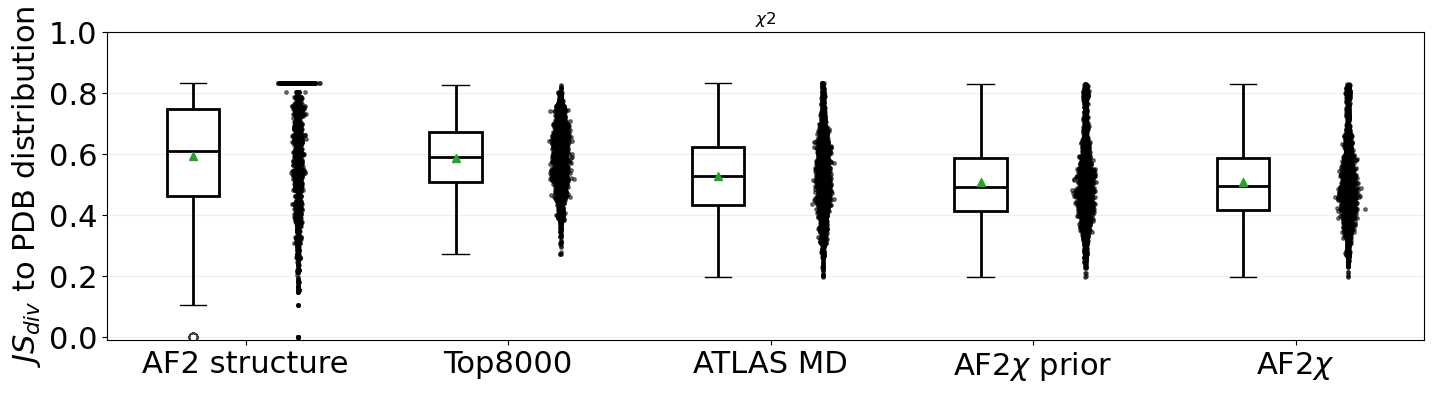

In [11]:
plot_boxplot_with_points_density(js_results_arrs['af2'], js_results_arrs['top8000'], js_results_arrs['md'], js_results_arrs['prior'], js_results_arrs['reweighted'], labels=['AF2 structure','Top8000', 'ATLAS MD','AF2$\chi$ prior','AF2$\chi$'], ylabel=r'$JS_{div}$ to PDB distribution',title=f'$\chi${chi_type[-1]}', spread_scale=0.0001)
plt.savefig(f'../figures/ATLAS_MD_pdbensref_all_{chi_type}_blacknwhite.pdf',bbox_inches='tight')


In [12]:
js_results_arrs_multi = {}
for ensemble_model in js_results_multi.keys():
    js_vs_residues_all_multi = np.array([])
    for js_vs_residues_multi in js_results_multi[ensemble_model].values():
        js_vs_residues_all_multi = np.concatenate((js_vs_residues_all_multi, js_vs_residues_multi))
    js_results_arrs_multi[ensemble_model] = js_vs_residues_all_multi

In [13]:
for ensemble_type in js_results_arrs_multi.keys():
    js_results_arrs_multi[ensemble_type] = js_results_arrs_multi[ensemble_type][np.isfinite(js_results_arrs_multi[ensemble_type])]

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_271235/1274696695.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(js_results_arrs_multi['af2'], js_results_arrs_multi['top8000'], js_results_arrs_multi['md'], js_results_arrs_multi['prior'], js_results_arrs_multi['reweighted'], labels=['AF2 structure','Top8000','ATLAS MD','AF2$\chi$ prior','AF2$\chi$'], ylabel=r'$JS_{div}$ to PDB distribution',title=f'$\chi${chi_type[-1]} multi-well residues', spread_scale=0.00015)
/tmp/ipykernel_271235/1274696695.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(js_results_arrs_multi['af2'], js_results_arrs_multi['top8000'], js_results_arrs_multi['md'], js_results_arrs_mu

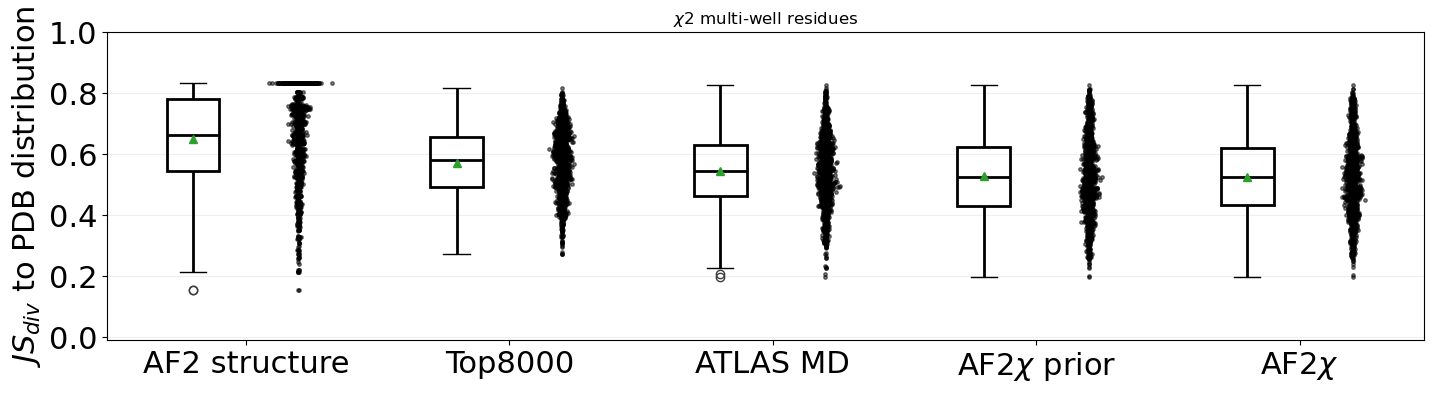

In [14]:
plot_boxplot_with_points_density(js_results_arrs_multi['af2'], js_results_arrs_multi['top8000'], js_results_arrs_multi['md'], js_results_arrs_multi['prior'], js_results_arrs_multi['reweighted'], labels=['AF2 structure','Top8000','ATLAS MD','AF2$\chi$ prior','AF2$\chi$'], ylabel=r'$JS_{div}$ to PDB distribution',title=f'$\chi${chi_type[-1]} multi-well residues', spread_scale=0.00015)
plt.savefig(f'../figures/ATLAS_MD_pdbensref_multi_{chi_type}_blacknwhite.pdf',bbox_inches='tight')


In [15]:
js_results_arrs_fixed = {}
for ensemble_model in js_results_fixed.keys():
    js_vs_residues_all_fixed = np.array([])
    for js_vs_residues_fixed in js_results_fixed[ensemble_model].values():
        js_vs_residues_all_fixed = np.concatenate((js_vs_residues_all_fixed, js_vs_residues_fixed))
    js_results_arrs_fixed[ensemble_model] = js_vs_residues_all_fixed

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_271235/2491301517.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(js_results_arrs_fixed['af2'], js_results_arrs_fixed['top8000'], js_results_arrs_fixed['md'], js_results_arrs_fixed['prior'], js_results_arrs_fixed['reweighted'], labels=['AF2 structure','Top8000','ATLAS MD','AF2$\chi$ prior','AF2$\chi$'], ylabel=r'$JS_{div}$ to PDB distribution',title=f'$\chi${chi_type[-1]} single-well residues', spread_scale=0.00008)
/tmp/ipykernel_271235/2491301517.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(js_results_arrs_fixed['af2'], js_results_arrs_fixed['top8000'], js_results_arrs_fixed['md'], js_results_arrs_f

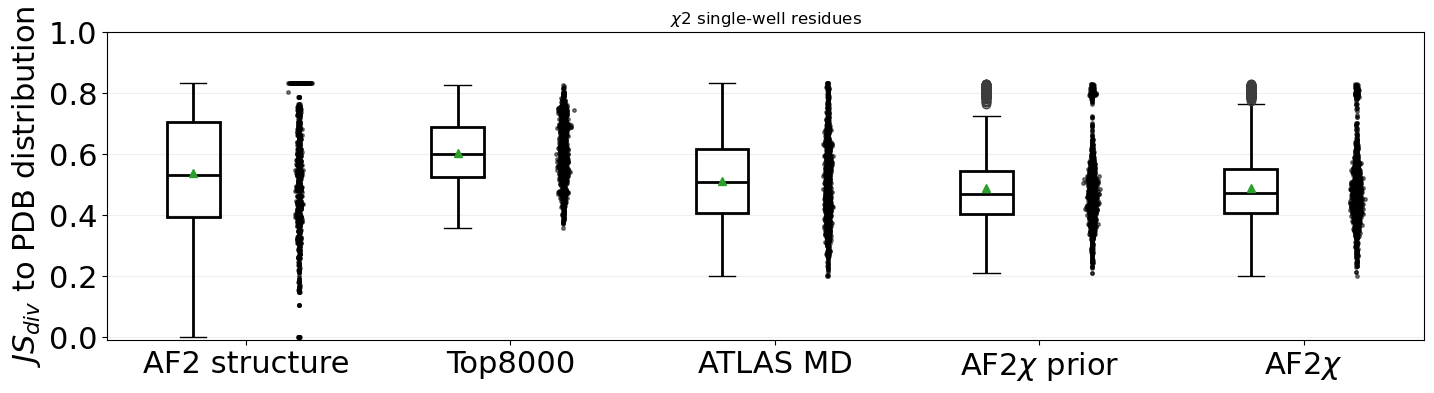

In [16]:
plot_boxplot_with_points_density(js_results_arrs_fixed['af2'], js_results_arrs_fixed['top8000'], js_results_arrs_fixed['md'], js_results_arrs_fixed['prior'], js_results_arrs_fixed['reweighted'], labels=['AF2 structure','Top8000','ATLAS MD','AF2$\chi$ prior','AF2$\chi$'], ylabel=r'$JS_{div}$ to PDB distribution',title=f'$\chi${chi_type[-1]} single-well residues', spread_scale=0.00008)
plt.savefig(f'../figures/ATLAS_MD_pdbensref_fixed_{chi_type}_blacknwhite.pdf',bbox_inches='tight')


In [17]:
af2_data = np.concatenate((js_results_arrs_fixed['af2'], js_results_arrs_multi['af2']))
top8000_data = np.concatenate((js_results_arrs_fixed['top8000'], js_results_arrs_multi['top8000']))
md_data = np.concatenate((js_results_arrs_fixed['md'], js_results_arrs_multi['md']))
prior_data = np.concatenate((js_results_arrs_fixed['prior'], js_results_arrs_multi['prior']))
reweighted_data = np.concatenate((js_results_arrs_fixed['reweighted'], js_results_arrs_multi['reweighted']))
colors = ['#D55C00']*len(js_results_arrs_fixed['af2']) + ['#56B4E9']*len(js_results_arrs_multi['af2'])

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_271235/2844141950.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(af2_data, top8000_data, md_data, prior_data , reweighted_data, labels=['AF2 structure','Top8000', 'ATLAS MD', 'AF2$\chi$ prior','AF2$\chi$'], colors=colors, ylabel=r'$JS_{div}$', spread_scale=0.0001)
/tmp/ipykernel_271235/2844141950.py:1: SyntaxWarning: invalid escape sequence '\c'
  plot_boxplot_with_points_density(af2_data, top8000_data, md_data, prior_data , reweighted_data, labels=['AF2 structure','Top8000', 'ATLAS MD', 'AF2$\chi$ prior','AF2$\chi$'], colors=colors, ylabel=r'$JS_{div}$', spread_scale=0.0001)


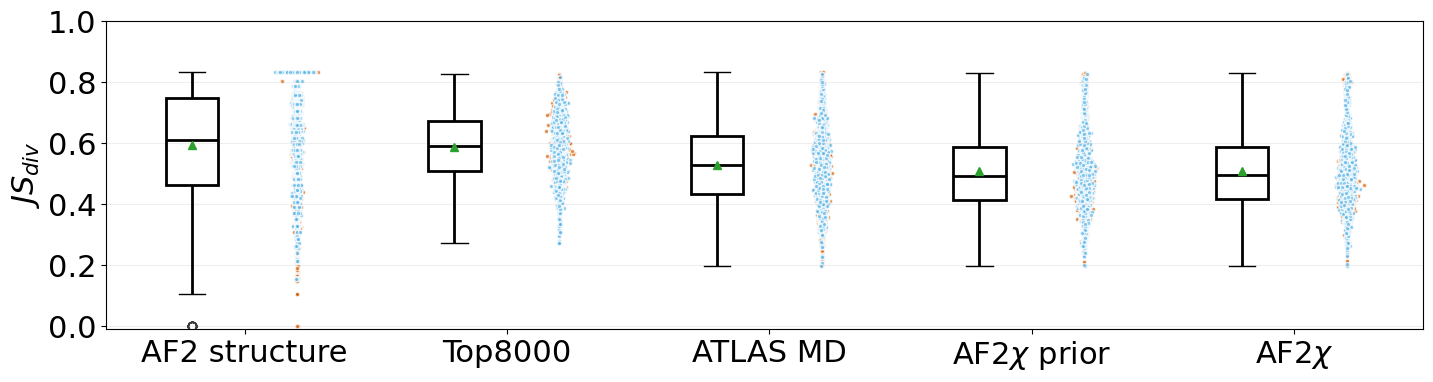

In [18]:
plot_boxplot_with_points_density(af2_data, top8000_data, md_data, prior_data , reweighted_data, labels=['AF2 structure','Top8000', 'ATLAS MD', 'AF2$\chi$ prior','AF2$\chi$'], colors=colors, ylabel=r'$JS_{div}$', spread_scale=0.0001)
plt.savefig(f'../figures/ATLAS_MD_pdbensref_all_{chi_type}.pdf',bbox_inches='tight')


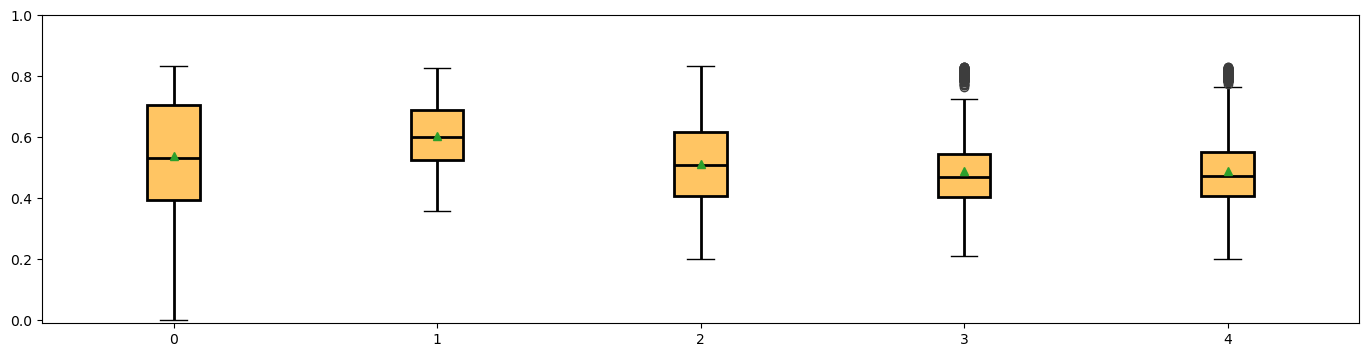

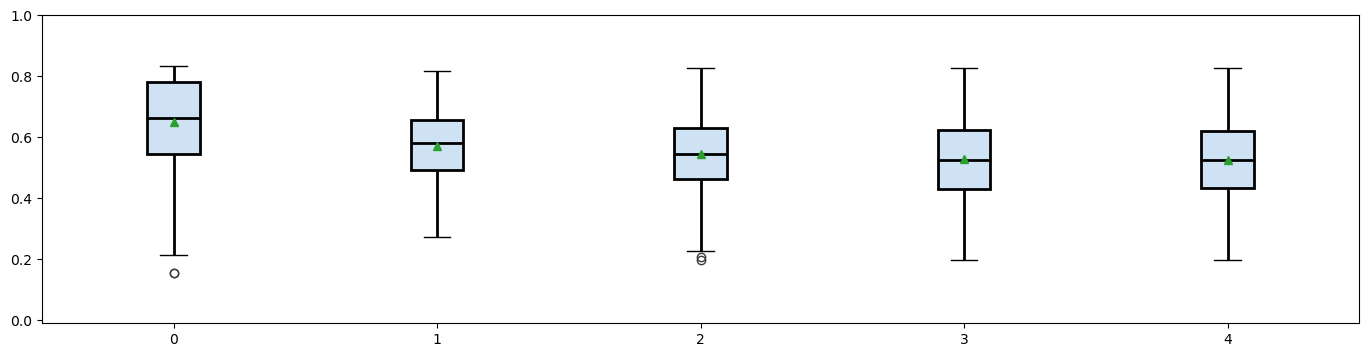

In [19]:
plot_boxplot(js_results_arrs_fixed['af2'], js_results_arrs_fixed['top8000'], js_results_arrs_fixed['md'], js_results_arrs_fixed['prior'], js_results_arrs_fixed['reweighted'],box_color='#ffc563',width=17,height=4,labelsize=19)
plt.savefig(f'../figures/ATLAS_MD_pdbensref_fixed_{chi_type}.pdf',bbox_inches='tight')
plot_boxplot(js_results_arrs_multi['af2'], js_results_arrs_multi['top8000'], js_results_arrs_multi['md'], js_results_arrs_multi['prior'], js_results_arrs_multi['reweighted'],box_color='#cfe2f3',width=17,height=4,labelsize=19)
plt.savefig(f'../figures/ATLAS_MD_pdbensref_multi_{chi_type}.pdf',bbox_inches='tight')
